In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#Uncomment next line when u first use nltk and press download when all in selected on the windows of nltk downloads
#nltk.download()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from collections import Counter

import string
from ast import literal_eval
from tqdm import tqdm
#To detect language for stemming
# https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes
#from langdetect import detect

## Import data

In [4]:
raw_data = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep = '\t')

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed, explore missing values, and delete rows with zero or one value present

In [5]:
columns2keep = ['energy_100g','sugars_100g','saturated-fat_100g','fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g','nutrition-score-uk_100g',
    'nutrition_grade_fr','main_category_en','packaging','categories','labels_en',
    'pnns_groups_1','pnns_groups_2','product_name','ingredients_text']

In [6]:
data = raw_data[columns2keep]

In [7]:
data = data.replace("unknown",np.nan)

In [8]:
data = data.loc[(~data.isnull()).sum(axis=1)>1]

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their Food Category. The PNNS ("Programme national nutrition santé" in French) aims at categorizing food in several major classes: Dairies, Composite, Fish Meat Eggs, Beverages, Fat Sauces, Fruits Vegetables, Starchy, and Snacks.

The PNNS categories were established by a variety of health professionals as part of the French National Nutrition and Health Program. In part, it aimed at dividing food products in well designed categories to have a frame of reference for the analysis of a population's nutrition and the advertisement of health plans. 

### From pnns_groups_1 column

We map the given pnns categories to our 8 major ones

In [9]:
data["pnns_groups_1"].value_counts()

Sugary snacks              57997
Milk and dairy products    43467
Fish Meat Eggs             42475
Cereals and potatoes       34187
Beverages                  29118
Fat and sauces             28114
Composite foods            25430
Fruits and vegetables      24419
Salty snacks               19825
sugary-snacks               3469
fruits-and-vegetables       2898
cereals-and-potatoes          43
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [10]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'food_category'] = data['pnns_groups_1'].map(pnns1_category)

In [11]:
# New pnns categories
data["food_category"].value_counts()

Snacks               81296
Dairies              43467
Fish Meat Eggs       42475
Starchy              34230
Beverages            29118
Fat Sauces           28114
Fruits Vegetables    27317
Name: food_category, dtype: int64

### From pnns_groups_2 column

We notice that several products haven't been categorized but have a non missing value in pnns_groups_2

In [12]:
# Values of pnns_groups_2 which haven't been classified in food_category
data.loc[data.food_category.isnull()]["pnns_groups_2"].value_counts()

One-dish meals            20805
Alcoholic beverages       10378
Pizza pies and quiche      2641
Sandwiches                 1984
Pizza pies and quiches      399
Name: pnns_groups_2, dtype: int64

Here, we make the decision to not classify Composite food as it doesn't pertain to a particular category. Also, creating a Composite category doesn't make sense for our final analysis.

In [13]:
data.loc[(data.food_category.isnull())&(data.pnns_groups_2 == "Alcoholic beverages"),"food_category"] = "Beverages"

In [14]:
data["food_category"].value_counts()

Snacks               81296
Dairies              43467
Fish Meat Eggs       42475
Beverages            39496
Starchy              34230
Fat Sauces           28114
Fruits Vegetables    27317
Name: food_category, dtype: int64

### From main_category_en column

We complete our categorization with the help of the 'main_category_en' column

In [15]:
data.loc[data.food_category.isnull()]["main_category_en"].value_counts().head(30)

Meals                              16758
Beverages                           9423
Plant-based foods and beverages     6785
Groceries                           5914
Snacks                              3724
Frozen foods                        3058
Dietary supplements                 1995
Sandwiches                          1760
Dairies                             1574
Canned foods                        1535
Desserts                            1286
Sweeteners                          1237
Baby foods                          1231
Meats                               1217
Cooking helpers                      740
Crêpes and galettes                  686
Food additives                       581
Non food products                    518
Spreads                              415
Cocoa and chocolate powders          322
Licensed products                    306
Syrups                               286
Chips and fries                      266
es:bolleria-industrial               237
fr:bloc-de-foie-

In [16]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.food_category.isnull(),'food_category'] =  data.loc[data.food_category.isnull(),'main_category_en'].map(maincategoryen_category)

In [17]:
sum(data["food_category"].value_counts())/len(data)

0.3465861548699095

**After these steps, we managed to categorize 34% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products stay unclassified. Also, the table beneath shows that no column with above 10% completeness for uncategorized data gives us direct information on food categories.

In [18]:
completeness = raw_data.iloc[data[data.food_category.isnull()].index].count().sort_values(ascending=False)/len(data.loc[data.food_category.isnull()])
completeness.loc[completeness>0.1]

code                                       1.000000
last_modified_t                            1.000000
pnns_groups_2                              1.000000
states                                     1.000000
states_tags                                1.000000
states_en                                  1.000000
last_modified_datetime                     1.000000
created_datetime                           1.000000
created_t                                  1.000000
creator                                    1.000000
url                                        1.000000
pnns_groups_1                              0.999348
countries                                  0.998852
countries_en                               0.998852
countries_tags                             0.998852
product_name                               0.994061
energy_100g                                0.940721
proteins_100g                              0.937988
carbohydrates_100g                         0.935718
fat_100g    

In [19]:
classified_data = data.loc[~data.food_category.isnull()]
unclassified_data = data.loc[data.food_category.isnull()]

In [20]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.6252760378548097

42% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We first use word similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column 

In [21]:
# We clean the list of ingredients by removing punctuation and numbers
def clean_text(df,col):
    caracters2delete = ['%','-',':',',',"  ",'(',')',';','/','_','*','\d+','.','\'','[',']','•','+']
    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')

clean_text(classified_data,"ingredients_text")
clean_text(unclassified_data,"ingredients_text")

# We then transform the text to a list of nonStop words
# The dominant language in the ingredients in french
stopWords = stopwords.words('french') + ["kg","g","v","a","b","k","e","mg","and","of","ml","cl"]

classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'] = \
    classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])
    
unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] = \
    unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'] \
    .apply(lambda x: [word for word in x.split() if word not in stopWords])

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
# We compute the set of words for each category by keeping the nFrequent most frequent words that aren't stopWords
nFrequent = 200
maxWords = 10

def createWordSet(df):   
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence[:maxWords]])
    count[""] = 0
    n = sum(count.values())
    return dict([(word[0],word[1]/n) for word in count.most_common(nFrequent)])

category_words = classified_data.groupby("food_category").apply(createWordSet)

ingredientDict = dict();
for col in category_words.index.values:
    for word in set(category_words[col]):
        ingredientDict[word] = ingredientDict.get(word,0)+1

ingredientDictList = list(ingredientDict)

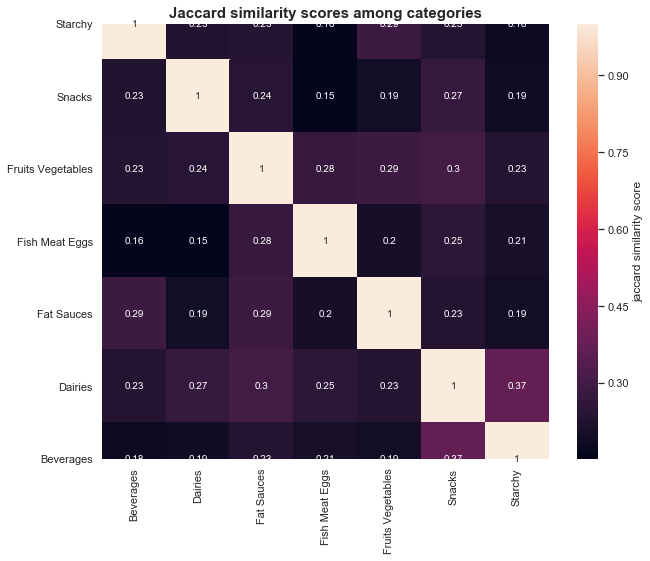

In [23]:
columns = category_words.index.values
n = len(columns)
similarity_matrix = np.zeros((n,n))

def jaccard_similarity(list1, list2):
    s1 = set(list1) # gives the keys
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

for idx1,name1 in enumerate(columns):
    for idx2,name2 in enumerate(columns):
        similarity_matrix[idx1,idx2] = jaccard_similarity(category_words[name1],category_words[name2])

plt.figure(figsize=(10,8))
sns.heatmap(similarity_matrix, annot=True, cbar_kws={'label': 'jaccard similarity score'})
plt.title("Jaccard similarity scores among categories", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.show()

We see that the dictionaries are rather distinct. The apparent similarities such as (Snacks/Starchy) and (Beverages/Fruits Vegetables) are senseful. Snacks and Starchy both have ingredients made with flour and Beverages such as juices can have fruit or vegetables.

To compute the similarity between a list of ingredients and a category, we compute a score. Each word in the ingredient list adds to the product's overall score its importance in the category dictionary (normalized count in the dictionary) which is also weighted by its position in the ingredients list. The idea is that the ingredients of a product are listed in order of importance, this is confirmed by the Open Food Facts website. We only consider the 10 first words in the ingredient list. We also divide the word score by the number of dictionaries in which it occurs. The ingredient is less representative of a food category if it also represents other categories.

We then categorize a product if its maximum similarity is above a certain threshold.

In [24]:
# Using similarities to category dictionaries

def similarity_dic(ingredients):
    dic = {}
    n = 10        
    for cat in category_words.index.values:
        score = 0
        for idx,word in enumerate(ingredients[:n]):
            score += category_words[cat].get(word,0)*(n-idx)/ingredientDict.get(word,1)
        dic[cat] = score
    total = sum(dic.values())
    if (total != 0) :
        dic = {k: v / total for k, v in dic.items()}
    return dic

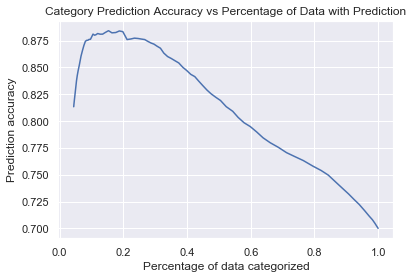

In [25]:
# We test different decision thresholds
thresholds = np.arange(0,1,0.01)
accuracies = []
percKept = []

test_similarities = classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"] \
            .apply(similarity_dic).apply(pd.Series)

test_similarities = test_similarities[(test_similarities.T != 0).any()]

for t in thresholds:
    results = test_similarities.loc[test_similarities.max(axis=1)>t].idxmax(axis=1)
    accuracies.append(sum(classified_data.loc[results.index,"food_category"] == results)/len(results))
    percKept.append(len(results)/len(test_similarities))

plt.plot(percKept,accuracies)

plt.title("Category Prediction Accuracy vs Percentage of Data with Prediction")
plt.xlabel("Percentage of data categorized")
plt.ylabel("Prediction accuracy")
plt.show() 


Here, the prediction accuracy is plotted for different decision thresholds and underlines the percentage of the data categorized with regards to the accuracy. We see that even for a high decision threshold, the accuracy rises only to 87% with only about 30% of the data classified. We decide to not use this classification method and study the optimality of a Random Forest classifier.

## Random Forest approach

We decide to do vector embeddings with the dictionary obtaining in the last section. The random forest approach is a natural choice for our classification task as the classification can be intuitively done with binary decisions on product ingredients.

In [26]:
def embedding_vector(l,dic_list):
    
    vec = np.zeros(len(dic_list))
    counter = 1
    for elem in l[::-1]:
        if elem in dic_list:
            vec[dic_list.index(elem)]+=counter
            counter+= 1

    if counter != 1:
        vec = vec/np.linalg.norm(vec)
        
    return vec

# Creation of inputs and outputs
training_X = classified_data.loc[~classified_data.ingredients_text.isnull(),'ingredients_text'].apply(lambda x : embedding_vector(x,ingredientDictList))
training_Y = classified_data.loc[~classified_data.ingredients_text.isnull(),"food_category"]


In [27]:
# We replace the categories by numerical values
cat_conv = {"Fruits Vegetables":0,"Starchy":1,"Fat Sauces":2,"Snacks":3,"Dairies":4,"Beverages":5,"Fish Meat Eggs":6}
training_Y = training_Y.replace(cat_conv)

# We create numpy arrays for the training
training_X = np.stack(training_X.values)
training_Y = np.array(training_Y.values)

Some products have no ingredients in the ingredient dictionary and have to be removed from the training set

In [28]:
nonZeroRowsIndexes = np.where(training_X.any(axis=1))[0]
print("Number of kept rows : {}, {:.2f}% of training data".format(len(nonZeroRowsIndexes),100*len(nonZeroRowsIndexes)/training_X.shape[0]))
training_X = np.take(training_X,nonZeroRowsIndexes,axis=0)
training_Y = np.take(training_Y,nonZeroRowsIndexes,axis=0)

Number of kept rows : 189310, 95.92% of training data


For a first evaluation of Random Forest classifiers, we now split our data into a training set and a test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(training_X, training_Y, test_size=0.33, random_state=2)
print("Number of training samples : {}".format(X_train.shape[0]))
print("Number of testing samples : {}".format(X_test.shape[0]))

Number of training samples : 126837
Number of testing samples : 62473


In [30]:
clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
clf.fit(X_train,y_train);
print("Accuracy score for test set : {:.2f}".format(accuracy_score(y_test,clf.predict(X_test))))

Accuracy score for test set : 0.87


Random Forest gives good results compared to our similarity method. We can always decide to not classify products whose classifier output probabilities are too low. The certainty threshold is set in a few blocks. We check the confusion matrix to see if misclassification is typical of certain categories.

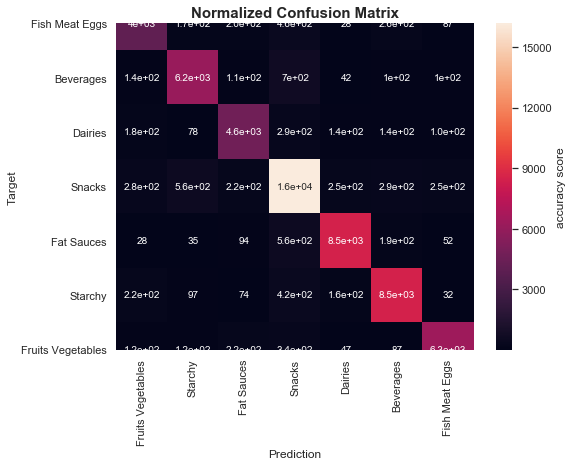

In [32]:
cm = confusion_matrix(y_test,clf.predict(X_test))
n = len(cat_conv)
columns = list(cat_conv)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cbar_kws={'label': 'accuracy score'})
plt.title("Normalized Confusion Matrix", fontsize=15, fontweight="bold")
plt.xticks(np.arange(n)+0.5,columns,rotation='vertical')
plt.yticks(np.arange(n)+0.5,np.flip(columns,axis=0),rotation='horizontal')
plt.ylabel("Target")
plt.xlabel("Prediction")
plt.show()

We notice that misclassification is rather spread out around the target/prediction possibilities and thus a simple probability threshold common to every class is sufficient to estimate certainty. We now estimate the threshold as a function of the accuracy we want, while trying to classify the most amount of products.

For validation purposes, we split out data 5 times into a training and testing set.

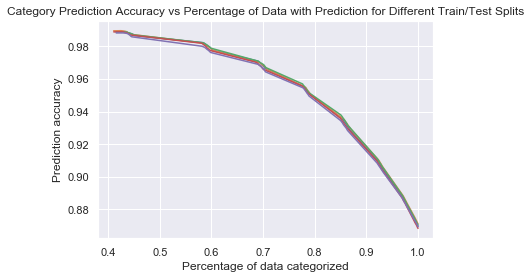

In [33]:
thresholds = np.arange(0,1.01,0.01)

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(training_X, training_Y, test_size=0.33, random_state=i)

    clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
    clf.fit(X_train,y_train)

    y_preds = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)
    y_probs_max = np.max(y_probs,axis=1)

    n = len(y_test)

    accuracies = []
    percKept = []

    for t in thresholds:
        y_test_kept = np.take(y_test,np.where(y_probs_max>=t)[0])
        y_preds_kept = np.take(y_preds,np.where(y_probs_max>=t)[0])
    
        percKept.append(len(y_test_kept)/n)
        accuracies.append(accuracy_score(y_test_kept,y_preds_kept))

    plt.plot(percKept,accuracies)

plt.title("Category Prediction Accuracy vs Percentage of Data with Prediction for Different Train/Test Splits")
plt.xlabel("Percentage of data categorized")
plt.ylabel("Prediction accuracy")
plt.show() 

We see as expected that there is a tradeoff between the classification accuracy and the percentage of the data that is classified. With high accuracy we can still classify a significant amount of our data which is great news.

In [34]:
wantedAccuracy = 0.98
bestThreshold = thresholds[np.where(np.asarray(accuracies)>wantedAccuracy)[0][0]]
expectedCatPercentage = percKept[np.where(np.asarray(accuracies)>wantedAccuracy)[0][0]]

print("By choosing a certainty threshold of {0:.2f} we categorized {1:.1f}% of the testing set with {2:}% accuracy." \
      .format(bestThreshold,expectedCatPercentage*100,wantedAccuracy*100))

clf = RandomForestClassifier(random_state=0,n_estimators=10,criterion="entropy")
clf.fit(training_X,training_Y);

By choosing a certainty threshold of 0.90 we categorized 58.2% of the testing set with 98.0% accuracy.


We now classify the unclassified data with the model trained on out whole training set.

In [35]:
unclassifiedWithIngred = unclassified_data.loc[~unclassified_data.ingredients_text.isnull(),'ingredients_text'].apply(lambda x : embedding_vector(x,ingredientDictList))
indexes = unclassifiedWithIngred.index
unclassifiedWithIngred = np.stack(unclassifiedWithIngred.values)

nonZeroRowsIndexes = np.where(unclassifiedWithIngred.any(axis=1))[0]
print("Number of kept rows : {}, {:.2f}% of unclassified data with ingredients_text".format(len(nonZeroRowsIndexes),100*len(nonZeroRowsIndexes)/unclassifiedWithIngred.shape[0]))

Number of kept rows : 243522, 96.69% of unclassified data with ingredients_text


In [36]:
# We makes the predictions and only keep those with max probability above the certainty threshold found earlier
dataToPredict = np.take(unclassifiedWithIngred,nonZeroRowsIndexes,axis=0)
indexes = np.take(indexes,nonZeroRowsIndexes,axis=0)
preds = clf.predict(dataToPredict)
probs = clf.predict_proba(dataToPredict)
probs_max = np.max(probs,axis=1)

y_preds_kept = np.take(preds,np.where(probs_max>=bestThreshold)[0])
indexes_kept = np.take(indexes,np.where(probs_max>=bestThreshold)[0])
    
print("We classifed {:.2f}% of the unclassified data with ingredients_text".format(100*len(y_preds_kept)/unclassifiedWithIngred.shape[0]))

We classifed 31.34% of the unclassified data with ingredients_text


In [37]:
# We translate our numerical categories back to strings
cat_conv_inv = {0:"Fruits Vegetables",1:"Starchy",2:"Fat Sauces",3:"Snacks",4:"Dairies",5:"Beverages",6:"Fish Meat Eggs"}
y_preds_kept = np.vectorize(cat_conv_inv.get)(y_preds_kept)

In [38]:
# We update our dataset
data.loc[indexes_kept,"food_category"] = y_preds_kept

classificationRatio = sum(data["food_category"].value_counts())/len(data)
print("We managed to classify {:.2f}% of the whole data".format(classificationRatio*100))

We managed to classify 43.33% of the whole data


In [39]:
data.loc[np.random.choice(indexes_kept,10,replace=False),["food_category","product_name"]]

,food_category,product_name
33810,Snacks,"Mentos, Drop, Chewy Sweets, Licorice"
562620,Fish Meat Eggs,Auchan 1/2 Filets De Poulet à La Provençale
90634,Dairies,Singles
112841,Snacks,"Russel Stover, Asorted Fine Chocolate"
54950,Snacks,Milk Chocolate Hearts
817639,Snacks,Thins galletas ginger
461576,Starchy,Farine de blé label rouge
222489,Snacks,"Red Plate Foods, Allergy Friendly Cookies, Oat..."
457449,Dairies,Perle de lait
178614,Snacks,Cookies 'N Cream Bites


# PACKAGING

While this field remains incomplete, it is still useful for us to analyze the packaging methods of different food categories. The processing pipeline for this field was performed as follows :
- clean 'Packaging' column of the dataframe by removing stop words and unecessary entries
- retain only certain material types of packaging (plastic, glass, cardboard, metal ...)
- plot the proportion of each material within a certain category of food

In [ ]:
# We build our list of stopwords to remove when tockenizing the packaging column
stop_words_c = set(stopwords.words("french")).union(set(stopwords.words("english")))

# 'can' was removed since it was in the stop words list but still useful for Beverages containers
stop_words_c.remove('can')

In [ ]:
# We clean the packaging column
def clean_data_packaging(data_column):
    """Clean data packaging, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
    """  
    
    tokenizer = RegexpTokenizer(r'\w+')
    data_column = data_column[data_column.notnull()].str.lower() \
    .apply(str) \
    .apply(tokenizer.tokenize) \
    .apply(lambda cell : [item for item in cell if item not in stop_words_c]) \
    .apply(str)
    
    return data_column


packaging = clean_data_packaging(data.packaging)
packaging = packaging.apply(literal_eval)
filled_pck = data.packaging.count()/len(data.packaging)

# We visualize some results
print(f'Packaging field is full at {filled_pck} %')
packaging.head()

**20% of the data has packaging information**
We now categorize the packaging information to defined packaging classes.

In [ ]:
# Vaccum items were added since it surely contains plastic
plastique_words = ['plastic', 'plastique', 'plastik', 'plastico', 'plastica', 'sachets', 
                   'plàstic', 'plástico', 'plastisco' ,'bucket', 'barquette', 'sachet', 'tube', 'film', 'vacio', 'vide', 'vacío']

verre_words = ['verre', 'glass', 'glas', 'vidrio', 'pot']
carton_words = ['paper', 'karton', 'carton', 'papier', 'boite', 'cartón', 'papel', 'cardboard', 
                'card', 'eggbox', 'box']

metal_words = ['metal', 'métal', 'fer', 'acier', 'aluminium', 'can', 'canette', 'conserve','tin']

# Fresh products needs an adapted container which is useful for further exploration
prod_frais_words = ['frais', 'fresh', 'frai']

# The recycable materials depend on the country and regulations. However, these materials are commonly recycable.
# (soiled papers, soiled metalic containers and soiled plastic containers tend to be avoided for medical reasons)
recyclable_words = ['bouteille', 'flacon', 'brique', 'brick', 'bottle', 'bte', 'verre', 
                    'glass', 'glas', 'vidrio', 'metal', 'métal', 'fer', 'acier', 'aluminium', 'flasche', 'canned', 
                    'can', 'canette', 'conserve', 'tin', 'pet', 'pot', 'botella']

def count_entries(self, word_list):
    """ Return true if word_list and self have a word in common,
        else o/w.
    """
    if len(set(self).intersection(set(word_list))) > 0:
        return True
    else :
        return False

def to_materials(elem):
    """ Return a list of bool that informs about the materials used 
        for the packaging.
    """
    return [count_entries(elem, plastique_words), 
               count_entries(elem, verre_words), 
               count_entries(elem, carton_words),
               count_entries(elem, metal_words),
               count_entries(elem, prod_frais_words),
               count_entries(elem, recyclable_words)]
    

In [ ]:
# We a create a boolean list for each value representing the membership to packaging methods and fresh/recycable attribute
materials_df = pd.DataFrame({'Packaging': packaging, 'materials':pd.Series(np.zeros(len(packaging)), packaging.index)})
materials_df['materials'] = packaging.apply(to_materials)

In [ ]:
# We create a dataframe with the information
names_list = ['Plastic', 'Glass', 'Carton', 'Metal', 'Fresh', 'Recyclable']
materials_df = materials_df.materials.apply(pd.Series)
materials_df = materials_df.rename(columns = lambda x : names_list[x])

In [ ]:
# We merge with the food categories
eco_impact_plot_df = materials_df.merge(data.loc[materials_df.index.tolist(), ["food_category"]], left_index = True, right_index = True)

In [ ]:
# We remove Fresh and Recycable categories and plot normalized bar plots for the packaging for each food category
packaging_plot_df = eco_impact_plot_df.drop('Fresh', axis =1)
packaging_plot_df = packaging_plot_df.drop('Recyclable', axis =1)
counts_pack = packaging_plot_df.groupby('food_category').sum()

plt.figure(figsize =(10,10))
ax=plt.gca()
counts_pack.div(counts_pack.sum(axis=1)/100, axis = 0).plot.bar(ax=ax, stacked=True)
plt.title('Material Use Percentage within each Category',fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Packaging Type Percentages");

While the sample size is limited, a few useful informations are depicted on the above plot. First we can see that a lot of plastic is used among every category. Moreover, glass is mainly used as a liquid container which is consistent with what we could expect. The packaging information along with the use of cooling containers and recyclability of products will be used in the analysis of different diets.

### DIET from labels_en

In [ ]:
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']

In [ ]:
def clean_caract(df,col):
    
    caracters2delete = ['%',':','(',')',';','/','_','*','\d+','.','\'','[',']']

    df.loc[:,col] = df.loc[:,col].str.lower()
    for c in caracters2delete:
        df.loc[:,col] = df.loc[:,col].str.replace(c,' ')


In [ ]:
data["split_labels_en"] = data["labels_en"]
clean_caract(data,"split_labels_en")
data.loc[:,"split_labels_en"] = data.loc[:,"split_labels_en"].str.split(',')


In [ ]:
is_vegetarian_list = ['vegetarian']
not_vegetarian_list = ['meat']
data["isVGT"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetarian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetarian_list for cat_word in l])))

is_vegetalian_list = ['vegan']
not_vegetalian_list = ['meat']
data["isVGL"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_vegetalian_list for cat_word in l]) &  \
                       any([cat_word in is_vegetalian_list for cat_word in l])))

is_glutenfree_list = ['gluten-free']
not_glutenfree_list = ['mais']
data["isGF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_glutenfree_list for cat_word in l]) &  \
                       any([cat_word in is_glutenfree_list for cat_word in l])))

is_lactosefree_list = ['no lactose']
not_lactosefree_list = ['lait']
data["isLF"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_lactosefree_list for cat_word in l]) &  \
                       any([cat_word in is_lactosefree_list for cat_word in l])))

is_organic_list = ['organic','eu organic','fr ab-agriculture-biologique']
not_organic_list = ['non organic']
data["isOG"] = data.loc[~data["split_labels_en"].isnull(),"split_labels_en"] \
.apply(lambda l : bool(~any([cat_word in not_organic_list for cat_word in l]) &  \
                       any([cat_word in is_organic_list for cat_word in l])))

In [ ]:
len(data[data["isVGT"]==True])

In [ ]:
len(data[data["isVGL"]==True])

In [ ]:
len(data[data["isGF"]==True])

In [ ]:
len(data[data["isLF"]==True])

In [ ]:
len(data[data["isOG"]==True])

In [ ]:
# almost all vegetalian are in vegetarian
len(data[(data["isVGL"]==True) & (data["isVGT"]==True)])/len(data[(data["isVGT"]==True)])

In [ ]:
# create data
diets_data = data[['food_category', 'isVGT', 'isVGL', 'isGF', 'isLF', 'isOG']]
diets_plot = diets_data.groupby('food_category').sum()

# Create a pieplot
fig, axes = plt.subplots(1,5, figsize=(30,20))
for ax, col in zip(axes, diets_data.columns[1:]):
    ax.pie(diets_plot[col], wedgeprops=dict(width=.3))
    ax.set(ylabel='', title=col, aspect='equal')
plt.legend(diets_plot.index, loc='center')
plt.show()

In [ ]:
diets_data.index

## Diet from ingredients

In [ ]:
carnivore_list = [
    'animal','animals',
    #viande
    'viande','viandes','meat','fleisch','carne',
    'bœuf','boeuf','boeufs','beef','steak','vache','cow', 'bovin','bovine',
    'charcut', 'charcuteries', 'charcuterie',
    'poulet','poulets','poule','poules','chicken','volaille','volailles',
    'porc','pork','jambons', 'jambon', 'jam','cerdo','lardon','lardons','bacon','schweinefleisch',
    'cannard','canard',
    'dinde','dindes', 'turkey',
    'boudin','foie','rillette','rillettes','couenne',
    'poitrine','cuisse','cuisses'
    'chipolata','chipolatas',
    'brebis', 'mouton'
    #poisson
    'poisson','fish', 'fisch',
    'sardine','sardines','sardina',
    'thon','thuna','tuna',
    'saumon','salmon', 'salmo'
    'hareng', 'seafood',
    'maquereaux','cabillaud','morue',
    'crevettes', 'shrimp',
    'albacore','colin','truite','moules'
]


In [ ]:
# Words which reference water
#carnivore_list = ["viande"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
soja_list = ["soja"]

# We clean the 'categories' column and split into words
data["split_ingredients_text"] = data["ingredients_text"]
clean_text(data,"ingredients_text")
data.loc[:,"split_ingredients_text"] = data.loc[:,"split_ingredients_text"].str.split()
#
#data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
#.apply(lambda l : bool(~any([cat_word in soja_list for cat_word in l]) &  \
#                       any([cat_word in carnivore_list for cat_word in l])))

In [ ]:
data["iscarnivore"] = data.loc[~data["split_ingredients_text"].isnull(),"split_ingredients_text"] \
.apply(lambda l : bool(any([cat_word in carnivore_list for cat_word in l])))

In [ ]:
data["iscarnivore"].value_counts()

# NUTRISCORE


A simple, readable, understandable graphic system

A triple objective
- Inform the consumer at the time of purchase to include the nutrition
dimension in the selection criteria (in addition to price, practicality,
taste, notoriety, label ...)
- Encourage producers to improve the nutritional quality of products
- Facilitate Health Professional advice on Nutrition

For the consumer a triple purpose:
- Compare the nutritional quality of foods from different categories
(ex : biscuits/dairy products/beverages....)
- Compare the nutritional quality of foods belonging to the same
category (ex : breakfast cereals)
- Compare the nutritional quality of the same food offered by
different brands ( ex : filled cereals)


The score comprises two dimensions: negative points (corresponding to the 'unfavourable' components, an
excess of which is considered unhealthy: calories, sugars, sodium and saturated fatty acids) and positive
points (corresponding to 'favourable' components: fruits, vegetables, pulses, nuts, and rapeseed, walnut
and olive oils, protein and fibre, an adequate amount of which is considered healthy).
- Between 0 and 10 points are awarded for each of these 4 'unfavourable' components, based on the
amount in 100 g of the food. Points are assigned based on the reference intake for the nutrient in
question. First, the 'unfavourable' components are totalled, resulting in a number of positive points
(maximum of +40).
- Between 0 and 5 points are awarded for the 3 'favourable' components (0 to 10 points for
beverages), based on the amount in 100 g of the food (maximum of -15).

Depending on the number of positive points, either all of the 'favourable' components are subtracted, or
only the fibre and, the “fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” components,
according to the following rules.
- If the total for the N component is less than 11 points, then the nutritional score is equal to the
total N component points minus the total for the P component.
- If the total for the N component is greater than or equal to 11 points and
    - If the total for “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” is equal to 5 (10 for beverages), then the nutritional score is equal to the total N component points minus the total for the P component.
    - If the total for “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils” is less than 5 (10 for beverages), then the nutritional score is equal to the total N component points minus the sum of the points for “fibres” and “Fruits, vegetables, pulses, nuts, and rapeseed, walnut and olive oils”. In this case, the protein content is therefore not taken into account in the calculation of the nutritional score.

The point table generally used to calculate the nutritional score is as follows:
- Points assigned for nutrients that have a negative impact on the nutritional score (N)


| Points N | Energy density (kJ/100g) | Sugars (g/100g) | Saturated fatty acids (g/100g) | Sodium (mg/100g) |
|:--------:|:------------------------:|:---------------:|:------------------------------:|:----------------:|
|     0    |           < 335          |      < 4.5      |               < 1              |       < 90       |
|     1    |           > 335          |      > 4.5      |               > 1              |       > 90       |
|     2    |           > 670          |       > 9       |               > 2              |       > 180      |
|     3    |          > 1005          |      > 13.5     |               > 3              |       > 270      |
|     4    |          > 1340          |       > 18      |               > 4              |       > 360      |
|     5    |          > 1675          |      > 22.5     |               > 5              |       > 450      |
|     6    |          > 2010          |       > 27      |               > 6              |       > 540      |
|     7    |          > 2345          |       > 31      |               > 7              |       > 630      |
|     8    |          > 2680          |       > 36      |               > 8              |       > 720      |
|     9    |          > 3015          |       > 40      |               > 9              |       > 810      |
|    10    |          > 3350          |       > 45      |              > 10              |       > 900      |





- Points attributed for nutrients that have a positive impact on the nutritional score (P) 

| Points P | Fruits, vegetables, pulses, nuts (%) | Fibre (g/100g) | Protein (g/100g) |
|:--------:|:------------------------------------:|:--------------:|:----------------:|
|     0    |                 < 40                 |      < 0.9     |       < 1.6      |
|     1    |                 > 40                 |      > 0.9     |       > 1.6      |
|     2    |                 > 60                 |      > 1.9     |       > 3.2      |
|     3    |                   -                  |      > 2.8     |       > 4.8      |
|     4    |                   -                  |      > 3.7     |       > 6.4      |
|     5    |                 > 80                 |      > 4.7     |        > 8       |

Methods for calculating the score: adaptations

- Fat and Sauces
    - The total saturated fatty acids/lipids calculation replaces the saturated fatty acids column, but the other columns must be used.
    
| Points N | Ratio (%) total saturated fatty acids/lipids  |
|:--------:|:---------------------------------------------:|
|     0    |                      < 10                     |
|     1    |                      < 16                     |
|     2    |                      < 22                     |
|     3    |                      < 28                     |
|     4    |                      < 34                     |
|     5    |                      < 40                     |
|     6    |                      < 46                     |
|     7    |                      < 52                     |
|     8    |                      < 58                     |
|     9    |                      < 64                     |
|    10    |                      > 64                     |

- Beverages
    - The calculation of the energy, total sugars and fruit and vegetables columns replaces the previous columns, but the other columns must be used. 
    
| Points | Energy density (kJ/100g or 100mL) | Sugars (g/100g or 100mL) | Fruits, vegetables, pulses, nuts (%) |
|:------:|:---------------------------------:|:------------------------:|:------------------------------------:|
|    0   |                < 0                |            < 0           |                 < 40                 |
|    1   |                < 30               |           < 1.5          |                   -                  |
|    2   |                < 60               |            < 3           |                 > 40                 |
|    3   |                < 90               |           < 4.5          |                   -                  |
|    4   |               < 120               |            < 6           |                 > 60                 |
|    5   |               < 150               |           < 7.5          |                   -                  |
|    6   |               < 180               |            < 9           |                   -                  |
|    7   |               < 210               |          < 10.5          |                   -                  |
|    8   |               < 240               |           < 12           |                   -                  |
|    9   |               < 270               |          < 13.5          |                   -                  |
|   10   |               > 270               |          > 13.5          |                 > 80                 |


- Cheeses
    - Cheese nutritional score = Total N points – Total P points

Assigning Colours


The Nutri-Score logo is attributed based on the score obtained (see table below).

| Solid foods points | Beverages points | Logo |
|:------------------:|:----------------:|:----:|
|      Min to -1     |      Waters      |   A  |
|        0 - 2       |      Min - 1     |   B  |
|       3 - 10       |       2 - 5      |   C  |
|       11 - 18      |       6 - 9      |   D  |
|      19 - Max      |     10 - Max     |   E  |

### Water Tag
In order to compute the NutriScore (NS) of products, we need to seperate water from other beverages.

In [ ]:
# Words which reference water
water_list = ["water","waters","eau","agua"]

# Some 'categories' values contain words refering to water but are liquors
# We thus create a list to discard such products
nonwater_list = ["alkoholische","alcoholic","spirits","liquors","tonic",'coconut','sodas','soda']

# We clean the 'categories' column and split into words
data["split_categories"] = data["categories"]
clean_text(data,"split_categories")
data.loc[:,"split_categories"] = data.loc[:,"split_categories"].str.split()

data["iswater"] = data.loc[~data["split_categories"].isnull(),"split_categories"] \
.apply(lambda l : bool(~any([cat_word in nonwater_list for cat_word in l]) &  \
                       any([cat_word in water_list for cat_word in l])))




In [ ]:
data[data["iswater"]==True][['product_name','split_categories']]

In [ ]:
data["iswater"].value_counts()

### Data Setup

In [ ]:
# replace NaN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(0, inplace=True)

In [ ]:
selected_fields =[
    'product_name','food_category',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g',
    'fiber_100g','proteins_100g',
    'nutrition-score-uk_100g',
    'nutrition_grade_fr',
    'iswater']

In [ ]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['food_category']=='Beverages'][selected_fields]
data_fatsauces = data[data['food_category']=='Fat Sauces'][selected_fields]
data_without_beverage_fat = data[(data['food_category']!='Fat Sauces') & (data['food_category']!='Beverages') ][selected_fields]                    

### Calculation of negative points

We attribute Negative points (N) to different nutritional factors that have to be limited: energy, sugar, saturated fat and sodium

In [ ]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

We attribute Positive points (P) to different nutritional factors that have to be promoted: fruit vegetable nuts pourcentage, fibers and proteins.

In [ ]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [ ]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

### Nutriscore calculation

In [ ]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'] = nutridata['fruits_points'].fillna(0)
nutridata['fiber_points'] = nutridata['fiber_points'].fillna(0)
nutridata['proteins_points'] = nutridata['proteins_points'].fillna(0)

In [ ]:
# calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [ ]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
        
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)
    
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

### Convertion of NutriScore into NutriLetter


In [ ]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']!=True)]
nutridata_not_beverages = nutridata[ nutridata['food_category']!='Beverages']
nutridata_beverages_water = nutridata[ (nutridata['food_category']=='Beverages') & (nutridata['iswater']==True)]

In [ ]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages_water = [nutridata['nutri-score_calculated'].min() - 1, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])
nutridata_beverages_water['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages_water['nutri-score_calculated'], letter_bins_beverages_water, labels=['a'])


In [ ]:
nutriframes = [nutridata_not_beverages, nutridata_beverages, nutridata_beverages_water]
nutridata = pd.concat(nutriframes)

nutridata['nutri-score_letter_CALCULATED'].value_counts().sum()

At the end of this process of NS calculation we obtain a NS for 770k product that represent almost 80% our the entire dataset

### Visualisation of proportion of NutriLetter label for each Food Category

In [ ]:
lettercounts =nutridata.groupby(['food_category','nutri-score_letter_CALCULATED']).count()['nutri-score_calculated']

plt.figure(figsize=(8,8))
ax=plt.gca()

lettercounts.unstack().div(lettercounts.unstack().sum(axis=1)/100,axis=0).plot.bar(ax=ax,stacked=True)
plt.legend(loc='center left')
plt.title("Normalized Bar Plot of Nutrition Grade for each Category",fontsize=20);
plt.xlabel("Food Category");
plt.ylabel("Nutrition Grade Percentage");

## comparation nutriletter rawdata vs calculated

In [ ]:
product_2nutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull())])
product_2nutriletter

In [ ]:
product_samenutriletter =len(nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']==nutridata['nutrition_grade_fr'])])
product_samenutriletter             
              

In [ ]:
nutri_df = nutridata[(nutridata['nutri-score_letter_CALCULATED'].notnull()) & (nutridata['nutrition_grade_fr'].notnull()) & (nutridata['nutri-score_letter_CALCULATED']!=nutridata['nutrition_grade_fr'])][['product_name','food_category','nutrition_grade_fr','nutri-score_letter_CALCULATED']]

In [ ]:
nutri_df.head(10)

In [ ]:
nutri_df['NG_fr'] = pd.factorize(nutri_df['nutrition_grade_fr'], sort=True)[0] + 1
nutri_df['NG_calc'] = pd.factorize(nutri_df['nutri-score_letter_CALCULATED'], sort=True)[0] + 1

In [ ]:
nutri_df['Diff'] = (nutri_df['NG_fr'] - nutri_df['NG_calc']).abs()

In [ ]:
nutri_df.head(10)

In [ ]:
nutri_df.drop(['product_name', 'nutrition_grade_fr', 'nutri-score_letter_CALCULATED'], axis = 1).groupby('food_category').mean().plot(kind='bar')

Logistic regression nutriscore

In [ ]:
selected_fields_regression =[
    'energy_100g','saturated-fat_100g','sugars_100g','sodium_100g',
    #'fruits-vegetables-nuts_100g','fiber_100g',
    'proteins_100g',
    'nutrition_grade_fr'
]

In [ ]:
dataregression = data[selected_fields_regression]
len(dataregression)

In [ ]:
dataregression = dataregression.loc[(~dataregression.isnull()).sum(axis=1)==len(selected_fields_regression)]

In [ ]:
len(dataregression)

In [ ]:
y = dataregression["nutrition_grade_fr"]
X = dataregression[selected_fields_regression].drop("nutrition_grade_fr",axis=1)

In [ ]:
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

In [ ]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def fitLogRegWithCesSearch(X_train,y_train,minC=1,maxC=10,CStep=1):

    Ces = np.linspace(minC, maxC, int((maxC-minC/CStep)+1))
    scores = []
    
    for c in Ces:
    
        model = LogisticRegression(C=c,random_state=0, solver='lbfgs', multi_class='multinomial')
        model.fit(X_train, y_train)
        # use the model to make predictions with the test data
        y_pred = model.predict(X_test)
        # how did our model perform?
        count_misclassified = (y_test != y_pred).sum()
        #print('Misclassified samples: {}'.format(count_misclassified))
        accuracy = metrics.accuracy_score(y_test, y_pred)
        #print('Accuracy: {:.2f}'.format(accuracy))
        scores.append(accuracy)
        
    plt.figure(1, figsize=(6, 6))
    ax = plt.gca()
    ax.plot(Ces,scores)

In [ ]:
fitLogRegWithCesSearch(X_train,y_train,minC=10,maxC=20,CStep=1)

# Diet Study 



### Helper functions for Diet Study

In [ ]:
def clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=False, langdetec=False, tokenize=False, stemming=False, lemmatizing=False, onlyEngStemmer=False, onlyFrStemmer=False, applyNounFilter=False):
    """function that appeals all cleaning methods depending of the booleans"""
    cleaned_data = pd.DataFrame()    
    cleaned_data[column_to_clean] = data[column_to_clean].copy()
    
    
    if langdetec:
        cleaned_data["languages"] = data[data[column_to_clean].notnull()][column_to_clean].apply(language_detection)
        #I found all the languages disponibles for stemming, and i map the corresponding name to the ISO_code found by langdetect.detect
        cleaned_data["languages"] = cleaned_data["languages"].map({"ar": "arabic", "da": "danish", "nl" : "dutch", "en": "english", "fi": "finnish", "fr": "french", "de": "german", \
                                  "hu": "hungarian", "it": "italian", "no": "norwegian", "ro": "romanian", "ru" : "russian", "es": "spanish", \
                                  "sv" :"swedish"})
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
       
    #tokenize column_to_clean : --> stemming + lemmatization need list of tokens
    if tokenize:
        cleaned_data[column_to_clean] = tokenize_data(cleaned_data[column_to_clean], stop_words, tokenizer, applyNounFilter)
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl")
    else: 
        cleaned_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_token.pkl") 
    
    #stemm column_to_clean column according to the language used
    if stemming:
        #for stemming, langdetection as to be made previously
        if (not(langdetec or onlyEngStemmer or onlyFrStemmer)):
            lang_data = pd.read_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_langdetect.pkl")
            cleaned_data["languages"] = lang_data["languages"].copy()
        
        cleaned_data = stemming_data(cleaned_data, column_to_clean, onlyEngStemmer, onlyFrStemmer)
        
        if saving:
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_stem.pkl")  
            
    elif lemmatizing: 
        #lemmatizing only works well for english words
        cleaned_data = lemmatizing_data(cleaned_data, column_to_clean, wordnet_lemmatizer)
        if saving: 
            cleaned_data.to_pickle("exploration/processed_pickle/"+str(column_to_clean)+"/out_lem")    

    return cleaned_data

def filter_nountag(tokenlist_cell):
    """keep only NN : nouns, singular or mass and NNS : noun,plural and NNP : proper noun"""
    
    postag_cell = pos_tag(tokenlist_cell)
    postag_cell_filtered = [tag for tag in postag_cell if ((tag[1]=='NNS') or (tag[1] == 'NN') or (tag[1] == "NNP"))]
    tokenlist_cell = [tag[0] for tag in postag_cell_filtered]
    
    return tokenlist_cell

def tokenize_data(data_column, stop_words, tokenizer, applyNounFilter = False, tok_gaps = False):
    """Clean data, i.e. 
        - lower each words in the cells of data_column
        - tokenize cells of data_column, i.e. from float type create list of string (token)
        - remove stopwords for the list of tokens for each cells of data_column
        - keep only tokens with tag = NN (noun), or NNS (noun, plural)
    """  
    if tok_gaps:
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(lambda x :  "".join([ch for ch in x if ch not in string.punctuation.replace("-", "")])) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words])
        if applyNounFilter:
            data_colun = data_column[data_column.notnull()].apply(filter_nountag)
    
    else: 
        data_column = data_column[data_column.notnull()].str.lower() \
            .apply(str) \
            .apply(tokenizer.tokenize) \
            .apply(lambda cell : [item for item in cell if item not in stop_words]) 
        if applyNounFilter:
            data_column = data_column[data_column.notnull()].apply(filter_nountag)
    
    return data_column

def language_detection(category_cell): 
    """take a cell containing a the string from unprocessed dataframe and detect the language"""
    tmp_cell = str()
    tmp_cell = category_cell
    
    #supress numbers in string
    tmp_cell = tmp_cell.replace('\d+', '')
    #supress punctuations
    tmp_cell = re.sub(r'[^\w\s]','', tmp_cell)
    #remove spaces in string
    tmp_cell = ''.join(tmp_cell.split())
    
    #check if the string contain only letters --> f**king 🍩 
    if tmp_cell.isalpha():
        language = detect(category_cell)
        return detect(category_cell)
    else: 
        return None

def stemming_data(df_lang, serie_tokenlist, onlyEngStemmer = False, onlyFrStemmer=False):
    """Take as argument : 
        - df_lang = dataframe containing a serie of tokenlist, and a serie "languages" of corresponding language
        - serie_tokenlist = string name of the serie of tokenlist to stem
    """
    
    if onlyEngStemmer: 
        stemmer = SnowballStemmer("english")
    elif onlyFrStemmer:
        stemmer = SnowballStemmer("french")
    
    for i in [1, 1]:
        for index, row in tqdm(df_lang[df_lang[serie_tokenlist].notnull()].iterrows()):
            if (onlyEngStemmer==False and onlyFrStemmer==False): 
                stemmer = SnowballStemmer(row["languages"])
            
            df_lang.loc[index,serie_tokenlist] = [stemmer.stem(token) for token in row[serie_tokenlist]]
 
        
    return df_lang

def lemmatizing_data(df, serie_tokenlist, wordnet_lemmatizer):
    """lemmatize serie containing token_list
        - serie_tokenlist = string name of the serie of tokenlist to lemmatize
        - df = dataframe containing "serie_tokenlist" column
        """
    for index, row in df[df[serie_tokenlist].notnull()].iterrows():
        df.loc[index,serie_tokenlist] =  [wordnet_lemmatizer.lemmatize(token, pos="n") for token in row[serie_tokenlist]]
        #if u lemmatize verbs --> pos = "-v"
    return df


## Data cleaning initialization

In [ ]:
saving = False
# note : Language detection is only needed for stemming, 
# and it is a very long run (~1h)
regimes = ['isVegetarian', 'isVegetalian', 'isGlutenfree', 'isLactosefree', 'isKetogenic', 'isOrganic']
#StopWords and Tokenizer Object initialization
stop_words = set(stopwords.words("french")).union(set(stopwords.words("english"))) #will remove only english and french stopwords
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

## Cleaning _categories_ field

We first clean the 'categories' field and save the result in pickle format.

### -> If column field has to be cleaned

The cell below aims to clean the "categories" field and save outputs of each steps of the cleaning in pickle format. 
* create a repository in processed_pickle which has the name of the column to clean, i.e. processed_pickle/categories/ is the repository in which pickles will be saved

In [ ]:
# column_to_clean = "categories"
# #language detection
# langdetect_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, langdetec = True)
# #tokenization
# tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, tokenize = True, applyNounFilter = True)
# #stemming --> good since it consider language
# stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, stemming = True)
# #lemmatize --> not very good since it does not consider language (only good for english)
# lem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving = True, lemmatizing = True)

### -> If column field already cleaned and saved in pkl

In [ ]:
column = "categories"
langdetect_data = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_langdetect.pkl")
categories_tok = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_token.pkl") 
categories_stem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_stem.pkl") 
categories_lem = pd.read_pickle("exploration/processed_pickle/"+str(column)+"/out_lem.pkl") 

In [ ]:
categories_dict = categories_stem[categories_stem["categories"].notnull()]["categories"].explode().value_counts()
for word in categories_dict[categories_dict>500].index:
    print(word)

## Diet Dictionary for _categories_ field

We create dictionary for each diets. They have a YES list and NO list. A product is considered part of the diet is it has at least ONE element in its YES list (if not empty) and NO element in its NO list (if not empty).

In [ ]:
# #Initialization needed to create a serie containing unauthorized items  for each of the diets
# unauthorized_categories = pd.Series(index = regimes).rename('unauthorized_categories')
# 
# unauthorized_listnames_categories = ['categories_' + str(x) + '_NOlist' for x in regimes]
# unauthorized_listnames_categories
# 
# #Initialization needed to create a serie containing authorized items for each of the diets
# authorized_catexgories = pd.Series(index = regimes).rename('authorized_labelsen')
# 
# authorized_listnames_categories = ['categories_' + str(x) + '_YESlist' for x in regimes]
# authorized_listnames_categories

In [ ]:
# GENERAL LISTS
viand_list =  ['foi', 'foie', 'steak', 'viand', 'sausag', 'viandes', 'meat', 'beef', 'poisson', 'charcut', 'charcuteries', 'charcuteri', 'poulet', 'poul', 'volaill', 'jambons', 'jambon', 'jam', 'rillet', 'sardin', 'thon', 'steak', 'saumon', 'salmon', 'escalop', 'dind', 'jam', \
               'terrin', 'boudin', 'animal', 'cannard', 'porc', 'lasagn', 'cuiss', 'fish', 'crevet', 'fleisch', 'vach', 'chipolat', 'fisch', 'lardon', 'bacon', 'hareng', 'seafood', 'chicken', 'breb', 'bovin']

lactose_list = ['fromag', 'lait', 'yaourt', 'bi', 'écrem', 'cream', 'crem', 'glac', 'milk', 'milks', 'dairi', 'dair', 'dairies', 'beurr', 'milch', 'milchprodukt', 'chee', \
                                'cake', 'crêp', 'bread', 'gâteau' , 'lait', 'butter', 'butt', 'cooki', 'emmental', 'comt', 'camembert', 'margarin', 'kas', 'cheddar', 'yogurt', 'yogur', 'yogurts']

gluten_list = ['pât', 'pasta', 'pâtiss', 'past', 'nouill', 'viennois', 'biscuit', 'biscuits', 'sauc', 'sauces', 'charcut', 'charcuteri', 'charcuteries', 'bread', 'crêp', 'gâteau', 'farin', 'farines', 'pizz', 'pizzas', 'cake', 'madelein', \
               'brotaufstrich', 'brot', 'beignet', 'lasagn', 'raviol', 'blé', 'wheat', 'bi', 'pies', 'kuch', 'muffin', 'gaufr', 'gaufret', 'biscott', 'cooki', 'cook', 'brot']

fruit_list =  ['fruits','fruit', 'multifruit', 'pomm', 'confitur','nectar', 'nect', 'jus', 'juic','frut', 'sorbet', 'tomat', 'tomato', 'orang', 'compotes', 'marmelad'] 

legum_list = ['legum', 'légum',  'plant', 'végétal', 'vegetal', 'pflanzlich', 'salad',  'verdur', 'haricot',  'amand', 'veget',  'carott', 'oignon']

fat_list = ['huil', 'oil', 'oils', 'fat', 'gras', 'grass'] 

egg_list = ['mayon', 'mayonnaises', 'mayonnaises', 'moutardes', 'mustard', 'egg', 'œuf']

# Vegetarian_NOlist = regimes(0)
notVegetarian_categories = viand_list
isVegetarian_categories = lactose_list + \
                        fruit_list + \
                        legum_list + \
                        fat_list + \
                        egg_list 

# Lactosefree = regime(3)
notLactosefree_categories = lactose_list
isLactosefree_categories = viand_list + \
                            fruit_list + \
                            legum_list + \
                            fat_list + \
                            ['céréal', 'céréales', 'cereal', 'getreid', 'pât', 'sauces', 'sauc', \
                            'chips', 'chip', 'confiseries', 'confiseri', 'pain', 'huil', 'vin', 'vinaigres', \
                            'vinaigr', 'vinaigret', 'miel',  'bonbon', \
                            'grain', 'sirop', 'pickl', 'flocon',  'oliv', \
                            'riz', 'moutardes', 'moutard', 'champignon', 'farin', 'farines', 'noiset', 'caf', 'bean', 'pasta',\
                            'escalop', 'flake', 'flak', 'bouillon', 'seed', 'wine', 'win', 'potato', 'sod', 'nut', 'nouill', 'lentill', 'candi', \
                            'corn', 'sel', 'sucr', 'thé', 'tournesol', 'semoul', 'vert', 'muesl', 'pur', 'épic', 'vanill', 'minéral', 'minerales']


#Vegan_NOlist = regimes(1)
notVegetalian_categories = lactose_list + \
                              viand_list + \
                              egg_list

isVegetalian_categories = legum_list + \
                           fruit_list 

#Glutenfree = regime(2)
notGlutenfree_categories = gluten_list
isGlutenfree_categories = fruit_list + \
                            legum_list + \
                            egg_list + \
                            fat_list


#Ketogenic = regimes(4)
notKetogenic_categories = fruit_list + \
                              ['sucr', 'confiseries', 'confiseri', 'confis' , 'nouill', 'semoul', 'legumin', 'légumin', 'potato', 'bean', 'haricot', 'lentill', 'lentill', 'riz', 'pasta', \
                               'pasta', 'milk', 'milks', 'sirop', 'candi', 'jus', 'juic', 'tart', 'marmelad', 'snack', 'snacks', 'biscuit', 'pât', 'confitur', 'chocolat', 'chocolats', 'chocol', \
                               'nectar', 'nect', 'bread', 'chip', 'chips', 'pain', 'miel', 'bonbon', 'compot', 'pâtiss']

isKetogenic_categories = lactose_list + \
                            viand_list + \
                            fat_list + \
                            egg_list  + \
                            legum_list + \
                            ['grain', 'nut', 'tomato', 'tomat', 'seed']



#Organic = regimes(5)
isOrganic_categories = []
notOrganic_categories = []


isRegimes_categories = [isVegetarian_categories, isVegetalian_categories, \
                      isGlutenfree_categories, isLactosefree_categories, \
                      isKetogenic_categories, isOrganic_categories]

notRegimes_categories = [notVegetarian_categories, notVegetalian_categories, \
                      isGlutenfree_categories, notLactosefree_categories, \
                      notKetogenic_categories, notOrganic_categories]

## Cleaning _labels_en_ field

The 'label_en' column is used to complete the diet attribution of products

In [ ]:
##here we use tokenizer gaps to keep compounds words (don't separate words with dashe, e.g. gluten-free --> "gluten-free")
#tokenizer_gaps = RegexpTokenizer('\s+', gaps=True)

In [ ]:
#column_to_clean = "labels_en"
#
##tokenization
#tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, tokenize=True)
##stemming --> good since it consider language
#stem_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, tok_gaps=False, saving=True, stemming=True, onlyEngStemmer=True)

In [ ]:
column = "labels_en"

label_tok = pd.read_pickle("exploration/processed_pickle/"+column+"/out_token.pkl")
label_stem = pd.read_pickle("exploration/processed_pickle/"+column+"/out_stem.pkl")

##With gap, gluten-free is not separated in 'gluten' 'free'
label_tokgap = pd.read_pickle("exploration/processed_pickle/"+column+"/out_tokengap.pkl")
label_stemgap = pd.read_pickle("exploration/processed_pickle/"+column+"/out_stemgap.pkl")

## Diet Dictionary for _labels_en_ field

The same methodology is used for obtaining diet information from the 'labels_en' column and completing our diet categorization

In [ ]:
data[data["labels_en"].notnull()]["labels_en"].value_counts().head(50)

In [ ]:
labelsen_dict = label_stem[label_stem["labels_en"].notnull()]["labels_en"].explode().value_counts()
for word in labelsen_dict[labelsen_dict > 1000].index:
    print(word)

In [ ]:
##Initialization needed to create a serie containing authorized items for each of the diets
#authorized_labelsen = pd.Series(index = regimes).rename('authorized_labelsen')
#
#authorized_listnames_labelsen = ['labelsen_' + str(x) + '_YESlist' for x in regimes]
#authorized_listnames_labelsen
#
##Initialization needed to create a serie containing unauthorized items  for each of the diets
#unauthorized_labelsen = pd.Series(index = regimes).rename('unauthorized_labelsen')
#
#unauthorized_listnames_labelsen = ['labelsen_' + str(x) + '_NOlist' for x in regimes]
#unauthorized_listnames_labelsen

In [ ]:
#Organic = regimes(5)
isOrganic_labels_en = ['organic', 'bio', 'biologique']
#Ketogenic = regimes(4)
isKetogenic_labels_en = []

#Lactosefree = regime(3) #since lactose only appears as NO lactose
isLactosefree_labels_en = ['lactose']

#Glutenfree = regime(2)
isGlutenfree_labels_en_gap = ['gluten-free']
isGlutenfree_labels_en  = ['gluten']

#Vegan_NOlist = regimes(1)
isVegetalian_labels_en = ['vegan']

#Vegetarian_NOlist = regimes(0)
isVegetarian_labels_en = ['vegetarian']

#isRegimes_labels_en_gap = [labelsen_Vegetarian_YESlist, labelsen_Vegetalian_YESlist, labelsen_Glutenfree_YESlistgap, \
#                    labelsen_Lactosefree_YESlist, labelsen_Ketogenic_YESlist, labelsen_Organic_YESlist]

isRegimes_labels_en = [isVegetarian_labels_en, isVegetalian_labels_en, isGlutenfree_labels_en, \
                    isLactosefree_labels_en, isKetogenic_labels_en, isOrganic_labels_en]

isRegimes_labels_en_gap = [isVegetarian_labels_en, isVegetalian_labels_en, isGlutenfree_labels_en_gap, \
                    isLactosefree_labels_en, isKetogenic_labels_en, isOrganic_labels_en]

## Diet Dictionary for _ingredients_text_ field

The same methodology is used for obtaining diet information from the 'ingredients_text' column and completing our diet categorization

In [ ]:
data[data["ingredients_text"].notnull()]["ingredients_text"]

In [ ]:
column = "ingredients_text"
# #tokenization  
# tok_data = clean_data(data, column_to_clean, stop_words, tokenizer, wordnet_lemmatizer, saving=True, tokenize=True)
# #stemming --> good since it consider language
# stem_data = clean_data(data, column, stop_words, tokenizer, wordnet_lemmatizer, saving=True, stemming=True, onlyFrStemmer=True)

In [ ]:
ingredientstext_tok = pd.read_pickle("exploration/processed_pickle/ingredients_text/out_token.pkl")
ingredientstext_stem = pd.read_pickle("exploration/processed_pickle/ingredients_text/out_stem.pkl")

In [ ]:
ingredientstext_tok_dict = ingredientstext_tok[ingredientstext_tok["ingredients_text"].notnull()]["ingredients_text"].explode().value_counts()


In [ ]:
ingredientstext_tok = pd.Series(data = ingredientstext_tok_dict[ingredientstext_tok_dict > 100])
ingredientstext_tok1000 = pd.Series(data = ingredientstext_tok.index)
ingredientstext_tok1000.to_csv("ingredients_text_tokens100.csv", sep = "\t", index = False)

In [ ]:
ingredientstext_dict = ingredientstext_stem[ingredientstext_stem["ingredients_text"].notnull()]["ingredients_text"].explode().value_counts()
for word in ingredientstext_dict[ingredientstext_dict > 1000].index:
    print(word)

In [ ]:
#Organic = regimes(5)
#isOrganic_ingredients_text = ['organic']
notOrganic_ingredients_text = ['TODO']

#Ketogenic = regimes(4)
#isKetogenic_ingredients_text = ['oil']
notKetogenic_ingredients_text = ['sucr','sucres','sugar','pât','ric', 'potato', 'barley', 'malted', 'orge', 'ble', 'cornstarch', 'avoin',\
                                 'froment', 'seigl',  'cereal', 'pâtiss', 'patat', 'houblon', 'sarrasin',\
                                 'épeautr', 'bread', 'sucros', 'seigle', 'wheat', 'basmat', 'corn', 'blé', 'pâte', 'riz', 'rice', 'zucker',\
                                 'céréales', 'potatoes', 'pasta', 'pain', 'biscuit', 'basmati', 'macaroni', 'patata', 'patate', 'riso',\
                                 'cereals', 'bière', 'cereales', 'noodles', 'nouilles', 'reis', 'orzo', 'weizenstärke', 'penne', 'ravioli',\
                                 'beer', 'weizen', 'frites', 'gâteau', 'pinda', 'patatas', 'potatis', 'lacto', 'pains',\
                                 'blé', 'avoine', 'orge','riz', 'quinoa', 'soya', 'chiches', 'lentille', 'gâteaux','haricots','miel','soda', ]

#Lactosefree = regime(3) 
#isLactosefree_ingredients_text = []
notLactosefree_ingredients_text = ['lait', 'milk', 'whey', 'pasteurized', 'lactos', 'lactiqu', 'fromag', 'cheddar', 'lactat', 'lactose',\
                                   'mozzarel', 'mozzarella', 'yogurt', 'emmental', 'lactylat', 'lactosérum', 'yaourt', 'milch', 'fromage',\
                                   'dairy', 'leit', 'cheese', 'pasteurisé', 'leche', 'lactic', 'latte', 'melk', 'leite', 'pasteurizada',\
                                   'pasteurisés', 'lactoserum', 'laitière', 'lactis', 'lactosa', 'laitiers', 'yogourt', 'pasteurised',\
                                   'pasteurisierte', 'feta', 'lactase', 'joghurt', 'gouda', 'laitier', 'mleko', 'cheeses', 'yoghurt',\
                                   'fromages', 'láctico', 'laitières', 'milcheiweiß', 'lalt', 'lattici', 'milchzucker', 'raclette',\
                                   'pasteurisiert', 'laktose', 'milchschokolade', 'pastorizzato', 'lacticos', 'pasteurizat', 'brie',\
                                   'roquefort', 'lactilato']

#Glutenfree = regime(2)
#isGlutenfree_ingredients_text  = [] 
notGlutenfree_ingredients_text = ['wheat', 'blé', 'ble', 'soj', 'soy', 'soybean', 'soja', 'soję', 'soya', 'soybeans', 'soia', 'sojalecithine',\
                                  'sojalecithin', 'lecithin', 'pât', 'orge', 'froment', 'seigl', 'épeautr', 'seigle', 'épeautre', 'epeautre',\
                                 'kamut','seigle','pates','pâtes','pate','pâte','raviolis','ravioli','gnocchi','boulghour','chapelure','pain',\
                                 'biscottes','viennoiseries','beignets','crepes','crêpes', 'gaufres','pâtisseries','biscuits','pané','quiches',\
                                 'cannelloni','hosties','biere','bière','panache','panaché']


#Vegetarian = regimes(0)
#isVegetarian_ingredients_text = []
notVegetarian_ingredients_text = ['porc', 'pork', 'por', 'viand', 'viande', 'meat', 'poulet', 'chicken', 'poisson',  'bœuf', 'boeuf', 'beef',\
                                  'jambon', 'vache', 'vach', 'canard', 'foi', 'foie', 'dind', 'dinde', 'cow', 'mollusqu', 'mollusque',\
                                  'mollusques', 'saumon', 'boyau', 'turkey', 'poul', 'bovin', 'volaill', 'volaille', 'poitrin', 'animal',\
                                  'crevet', 'couen', 'couenne', 'bacon', 'poissons', 'thon', 'shrimp', 'chipotl', 'vac', 'veau', 'salmo',\
                                  'fish', 'thicken', 'carn', 'crustacés', 'chèvre', 'bovine', 'os', 'brebis', 'vaca', 'crevettes', 'carne',\
                                  'lard', 'viandes', 'fleisch', 'boeufs', 'steak', 'charcut', 'charcuteries', 'charcuterie', 'poulets', \
                                  'poule', 'poules', 'volailles', 'jambons',  'cerdo', 'lardon', 'lardons', 'schweinefleisch', 'cannard',\
                                  'ancho', 'cabillaud', 'nuggets', 'homard', 'magret', 'harengus', 'porcini', 'colin', 'dindes', 'speck',\
                                  'escargots', 'boudin', 'rillette', 'rillettes', 'saucisse', 'épaule', 'serrano', 'truite', 'salami',\
                                  'poitrine', 'cuisse', 'cuisses', 'agneau', 'merguez', 'crevette', 'merlu', 'hareng', 'chipolata',\
                                  'chipolatas', 'mouton', 'halal', 'kidney', 'chorizo', 'crabe', 'lapin', 'sardines', 'porcine', 'anchois',\
                                  'taurine', 'ham', 'sheep', 'saucisses', 'fillets', 'crab', 'goat', 'crustacé', 'anchovies', 'pollo',\
                                  'couennes', 'morue', 'moules', 'saucisson', 'fisch', 'sardine', 'sardina', 'thuna', 'tuna', 'salmon',\
                                  'seafood', 'maquereaux', 'albacore', 'rib', 'shea', 'crumbs', 'gelatine']


#Vegan = regimes(1)
#isVegetalian_ingredients_text = []
notVegetalian_ingredients_text = notVegetarian_ingredients_text + notLactosefree_ingredients_text + \
                                 ['egg', 'eggs', 'œuf', 'œufs', 'oeuf', 'oeufs', 'ceufs', 'honey', 'abeille', 'miel', 'gélatin', 'chevr',\
                                  'chèvre', 'mayon', 'yolks', 'yolk', 'milkfat', 'torula', 'animale', 'animal', 'ceuf', 'beeswax', 'animaux',\
                                  'eufs', 'euf', 'auf', 'miels', 'miele']

#isRegimes_ingredients_text = [isVegetarian_ingredients_text, isVegetalian_ingredients_text, isGlutenfree_ingredients_text, \
#                                isLactosefree_ingredients_text, isKetogenic_ingredients_text, isOrganic_ingredients_text]

notRegimes_ingredients_text = [notVegetarian_ingredients_text, notVegetalian_ingredients_text, notGlutenfree_ingredients_text, \
                                notLactosefree_ingredients_text, notKetogenic_ingredients_text, notOrganic_ingredients_text]


## Diet series creation

We create the series representing possible the diet regimes of products

In [ ]:
def isDiet(input_df, split_col, regimes, isRegimes_lists = None, notRegimes_lists = None): 
    """Create isDiet columns (isVegetarian, isVegetalian,...) containing bool cell for each product, True or False. It takes into account notRegime_lists and isRegime_lists"""
    data = input_df.copy()
    for index, isRegime in enumerate(regimes): 
        
        if ((isRegimes_lists!=None) & (notRegimes_lists==None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            tmp_diet = tmp_data.apply(lambda token_list : bool(any([token in isRegimes_lists[index] for token in token_list])))
            
            #If isRegime already exist, just complete the lines still NaN, or Bool that are False
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif (isRegimes_lists!=None) & (notRegimes_lists!=None): 
            tmp_data = data.loc[data[split_col].notnull(), split_col].copy()
            
            tmp_diet_not = tmp_data.apply(lambda token_list : bool ((any([token in notRegimes_lists[index] for token in token_list])))).apply(lambda boolean: not(boolean))
            tmp_diet_is =  tmp_data.apply(lambda token_list : bool ((any([token in isRegimes_lists[index] for token in token_list]))))
            
            tmp_diet = pd.DataFrame()
            tmp_diet["not"] = tmp_diet_not
            tmp_diet["is"] = tmp_diet_is
            
            tmp_diet = tmp_diet.apply(lambda row : isAndnot(row), axis = 1)
            
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
            
        elif ((isRegimes_lists==None) & (notRegimes_lists!=None)):
            tmp_data = data.loc[data[split_col].notnull(), split_col]
            tmp_diet = tmp_data.apply(lambda token_list : bool ((any([token in notRegimes_lists[index] for token in token_list])))).apply(lambda boolean: not(boolean))
            
            if isRegime in data.columns:
                index1 = data[(data[isRegime]==False) | (data[isRegime].isnull())].index
                index2 = tmp_diet.index
                data.loc[index1.intersection(index2), isRegime] = tmp_diet.loc[index1.intersection(index2)]
            else: 
                data[isRegime] = tmp_diet
                
    return data

def isAndnot(row): 
    return row["is"] and row["not"]

### Let's test if ___isDiet()___ works

In [ ]:
#Test if isDiet booleans check if word in/not in list work as needed. 
testdf_categories = pd.DataFrame()
testserie_categories = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
testseries1_categories = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], [''], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
testdf_categories["categories_tok"] = testserie_categories
testdf_categories["expected_output"] = testseries1_categories
testdf_categories

In [ ]:
testdf_categories = isDiet(testdf_categories, "categories_tok", regimes[:5], isRegimes_lists = isRegimes_categories[:5], notRegimes_lists = notRegimes_categories[:5])
testdf_categories

In [ ]:
testdf_categories = isDiet(testdf_categories, "categories_tok", regimes[:5], notRegimes_lists = notRegimes_categories[:5])
testdf_categories

>Seems to works well when creating the new fields. Let's see if it also works when the field has already been created et when it only needs to complete None and False 

In [ ]:
test_df = pd.DataFrame()
test_serie = pd.Series([[str('mayon'), str('pasta'), str('milk'), str('fruits')], \
                        [str('pasta'), str('fruits')], \
                        [str('steak'), str('milk'), str('fruits')], \
                        [str('steak'), str('pasta'), str('fruits')],\
                        [str('steak'), str('pasta'), str('milk')], \
                        [str('')], \
                        [str('mayon'), str('milk'), str('fruits')], \
                        [str('milk'), str('fruits')], \
                        [str('steak'), str('fruits')], \
                        [str('steak'), str('milk')], \
                        [str('steak'), str('pasta'), str('milk'), str('fruits')]])
test_serie1 = pd.Series([[''], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['gluten'], \
                         [''], \
                         [''], \
                         [''], \
                         [''], \
                         ['']])
test_serie2 = pd.Series([['vege'], ['vegan + vege + lactose-free'], ['gluten-free'],['lactose-free'], ['ketogenic'], ['gluten-free'], ['vege + gluten-free'], \
                         ['vege + gluten-free'], ['gluten-free + lactose-free'], ['gluten-free + ketogenic'], ['All False']])
test_df["categories_tok"] = test_serie
test_df["labelsen_tok"] = test_serie1
test_df["expected_output"] = test_serie2
test_df

In [ ]:
test_df = isDiet(test_df, "categories_tok", regimes[:5], isRegimes_lists = isRegimes_categories[:5], notRegimes_lists = notRegimes_categories[:5])
test_df = isDiet(test_df, "labelsen_tok", regimes[:5], isRegimes_lists = isRegimes_labels_en[:5])
test_df

>Seems to work well in that case too! (see line 5). Lets try on the real data

### Let's try with _labels_en_

In [ ]:
#Here we use the tokenizer with gaps = True (keep gluten-free as 'gluten-free')
data["labels_en_tokgap"] = label_stemgap["labels_en"]
dietdf_labels_en_gap = isDiet(data, "labels_en_tokgap", regimes, isRegimes_lists = isRegimes_labels_en_gap)

#Here we use the normal tokenizer (gluten-free becomes 'gluten' 'free')
data["labels_en_tok"] = label_stem["labels_en"]
dietdf_labels_en = isDiet(data, "labels_en_tok", regimes, isRegimes_lists = isRegimes_labels_en)


In [ ]:
print("Using labels_en field with gap tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]/len(dietdf_labels_en_gap)*100
        nb_true = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_labels_en_gap[dietdf_labels_en_gap["labels_en_tokgap"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                

    
print("\n\n Using labels_en field with normal tokenizer, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_labels_en)*100
        nb_true = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

>Regarding the previous output, we will use preferentially the normal tokenizer

In [ ]:
for index, isRegime in enumerate(regimes):
    if (len(dietdf_labels_en[dietdf_labels_en["labels_en_tok"].notnull()][isRegime].value_counts()) == 2):
        print("\n"+isRegime+" --> 3 True samples:")
        samples_true = dietdf_labels_en[dietdf_labels_en[isRegime]==True]["labels_en"].sample(n=3, random_state=1)
        print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    samples_false = dietdf_labels_en[dietdf_labels_en[isRegime]==False]["labels_en"].sample(n=3, random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")

### Let's try with _categories_

##### First we use both : isRegimes_lists and notRegimes_lists

In [ ]:
data["categories_tok"] = categories_stem["categories"]
dietdf_categories = isDiet(data, "categories_tok", regimes, isRegimes_lists=isRegimes_categories, notRegimes_lists=notRegimes_categories)

In [ ]:
dietdf_categories[dietdf_categories["categories_tok"].notnull()]["isOrganic"].value_counts().index[0]

In [ ]:
print("\n\n Using categories field isRegimes_lists and notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_categories)*100
        nb_true = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().index[0] == False):
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().index[0] == True):
            percentage = 0; 
            nb_true = dietdf_categories[dietdf_categories["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

In [ ]:
for index, isRegime in enumerate(regimes):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_categories[dietdf_categories[isRegime]==True]["categories"])
    samples_true = dietdf_categories[dietdf_categories[isRegime]==True]["categories"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_categories[dietdf_categories[isRegime]==False]["categories"])
    samples_false = dietdf_categories[dietdf_categories[isRegime]==False]["categories"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")

##### Secondly we only use notRegimes_lists

In [ ]:
data["categories_tok"] = categories_stem["categories"]
dietdf_categories_1 = isDiet(data, "categories_tok", regimes, notRegimes_lists=notRegimes_categories)

In [ ]:
print("\n\n Using categories field notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[1]/len(dietdf_categories_1)*100
        nb_true = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

In [ ]:
for index, isRegime in enumerate(regimes):
    #if (len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_categories_1[dietdf_categories_1[isRegime]==True]["categories"])
    samples_true = dietdf_categories_1[dietdf_categories_1[isRegime]==True]["categories"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_categories_1[dietdf_categories_1[isRegime]==False]["categories"])
    samples_false = dietdf_categories_1[dietdf_categories_1[isRegime]==False]["categories"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")

>Regarding the results, we will only use notRegimes_categories for classification, more over, we might not classify organic diets, since it does not correspond to a specific type of diet but more to a label of quality. 

In [ ]:
isRegimes_labels_en = isRegimes_labels_en[:5]
notRegimes_categories = notRegimes_categories[:5]
notRegimes_ingredients_text = notRegimes_ingredients_text[:5]
regimes = regimes[:5]

In [ ]:
regimes

### Let's try with _ingredients_text_

In [ ]:
data["ingredients_text_tok"] = ingredientstext_stem["ingredients_text"]
dietdf_ingredients_text = isDiet(data, "ingredients_text_tok", regimes, notRegimes_lists=notRegimes_ingredients_text)

In [ ]:
print("\n\n Using ingredients_text field notRegimes_lists, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    if len(dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[1]/len(dietdf_ingredients_text)*100
        nb_true = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()[0]
    elif len(dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts()) == 1:
        if (dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf_ingredients_text[dietdf_ingredients_text["ingredients_text"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime)) 

In [ ]:
for index, isRegime in enumerate(regimes):
    #if (len(dietdf_categories_1[dietdf_categories_1["categories_tok"].notnull()][isRegime].value_counts()) == 2):
    print("\n"+isRegime+" --> 3 True samples:")
    length_true = len(dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==True]["ingredients_text"])
    samples_true = dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==True]["ingredients_text"].sample(n=min(3,length_true), random_state=1)
    print(samples_true)
    
    print("\n"+isRegime+" --> 3 False samples:")
    length_false = len(dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==False]["ingredients_text"])
    samples_false = dietdf_ingredients_text[dietdf_ingredients_text[isRegime]==False]["ingredients_text"].sample(n=min(3,length_false), random_state=1)
    print(samples_false)
    
    print("--------------------------------------------------")

### Merging the results. 

Keeping in mind that _labels_en_ founding is prioritary (diet are explicit in that field)

In [ ]:
dietdf = data.copy()
dietdf["labels_en_tok"] = label_stem["labels_en"]
dietdf["categories_tok"] = categories_stem["categories"]
dietdf = isDiet(dietdf, 'labels_en_tok', regimes, isRegimes_lists = isRegimes_labels_en)

print("Using labels fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                



dietdf = isDiet(dietdf, 'categories_tok', regimes, notRegimes_lists = notRegimes_categories)

print("\n Using labels_en + categories fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["categories_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))                                                

    
dietdf = isDiet(dietdf, 'ingredients_text_tok', regimes, notRegimes_lists=notRegimes_ingredients_text)

print("\n Using labels_en + categories + ingredients_text fields, we managed to classified : \n")
for index, isRegime in enumerate(regimes):
    
    if len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 2:
        percentage = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]/len(dietdf)*100
        nb_true = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[1]
        nb_false = dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()[0]
        
    elif len(dietdf[dietdf[isRegime].notnull()][isRegime].value_counts()) == 1:
        if (dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().index[0] == False): 
            percentage = 0; 
            nb_true = 0; 
            nb_false = dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().loc[False]
        elif (dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().index[0] == True): 
            percentage = 0; 
            nb_true = dietdf[dietdf["ingredients_text_tok"].notnull()][isRegime].value_counts().loc[True]; 
            nb_false = 0
        
    print("%s : %d True and %d False --> %d %%  product of total data set %s" % (isRegime, nb_true, nb_false, percentage, isRegime))      


In [ ]:
index_nanlab = dietdf[dietdf["labels_en"].isnull()].index
index_notnanlab = dietdf[dietdf["labels_en"].notnull()].index
index_nancat = dietdf[dietdf["categories"].isnull()].index
index_notnancat = dietdf[dietdf["categories"].notnull()].index
index_naning = dietdf[dietdf["ingredients_text"].isnull()].index
index_notnaning = dietdf[dietdf["ingredients_text"].notnull()].index

for index, isRegime in enumerate(regimes):
    index_true =  dietdf[dietdf[isRegime]==True].index
    index_false =  dietdf[dietdf[isRegime]==False].index

    
    print("\n\n================"+isRegime+"================")
    print("\n--> 3 True samples found by categories:")
    len_true_cat = len(dietdf.loc[index_true.intersection(index_nanlab).intersection(index_naning),["categories"]])
    samples_true_cat = dietdf.loc[index_true.intersection(index_nanlab).intersection(index_naning),["categories"]].sample(n=min(3, len_true_cat), random_state=1)
    print(samples_true_cat)
    
    print("\n--> 3 True samples found by labels_en:")
    len_true_lab = len(dietdf.loc[index_true.intersection(index_nancat).intersection(index_naning),"labels_en"])
    samples_true_lab = dietdf.loc[index_true.intersection(index_nancat).intersection(index_naning),"labels_en"].sample(n=min(3,len_true_lab), random_state=1)
    print(samples_true_lab)
    
    print("\n--> 3 True samples found by ingredients_text:")
    len_true_ing = len(dietdf.loc[index_true.intersection(index_nancat).intersection(index_nanlab),"ingredients_text"])
    samples_true_ing = dietdf.loc[index_true.intersection(index_nancat).intersection(index_nanlab),"ingredients_text"].sample(n=min(3,len_true_ing), random_state=1)
    print(samples_true_ing)
    
    print("\n--> 3 False samples:")
    len_false = len(dietdf.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning),["categories", 'labels_en', 'ingredients_text']])
    samples_false = dietdf.loc[index_false.intersection(index_notnancat).intersection(index_notnanlab).intersection(index_notnaning),["categories", 'labels_en', 'ingredients_text']].sample(n=min(3,len_false), random_state=1)
    print(samples_false)
    

>TODO.. Can't figure out for now why Viandes, Charcuteries, Saucissons, Saucisses s... is categorized as Gluten-Free since we have the stemmed token "charcut" in the notGlutenfree_categories list, the isDiet might not work exactly as expected.. 

### Accuracy Estimation

Since we know the classification by _labels_en_ to be __True__, we want to analyse how well we classify using _categories_ by comparing the number of differents outputs in the common product classified by both fields

In [ ]:
dietdf_categories= isDiet(dietdf_categories, 'categories_tok', regimes, isRegimes_lists =isRegimes_categories, notRegimes_lists=notRegimes_categories)
dietdf_labels_en = isDiet(dietdf_labels_en, 'labels_en_tok', regimes, isRegimes_lists = isRegimes_labels_en)

In [ ]:
for index, isRegime in enumerate(regimes):
    index_cat = dietdf_categories[dietdf_categories[isRegime].notnull()].index
    index_lab = dietdf_labels_en[dietdf_labels_en[isRegime].notnull()].index
    
    index_inter = index_cat.intersection(index_lab)
    
    common_cat = dietdf_categories.loc[index_inter, isRegime].astype(int)
    common_lab = dietdf_labels_en.loc[index_inter, isRegime].astype(int)
    
    commonPlus = common_lab + common_cat 
    commonMinus = common_lab - common_cat
    out_serie =  commonPlus.value_counts(normalize = True).sort_index()
    out_serie1 =  commonMinus.value_counts(normalize = True).sort_index()
    #If we want to compare both series, when common_lab is True (i.e = 1), it is the correct classification, so if common_cat has False (i.e = 0) on that cell, then
    #1 + 0 will return 1, 
    #0 + 0 will return 0, 
    #1 + 1 will return 2 
    #So correctly classified correspond to 0 and 2, uncorreclty classified correspond to 1
    print("\n\n" + isRegime + "\n")
    for index, value in out_serie.items():
        print("    Index : {}, Proportion : {}".format(index, round(value,4)))
        #0 : False correclty classified
        #1 : Uncorrect classification
        #2 : True correcly classified
    print("\n")
    for index, value in out_serie1.items():
        print("    Index : {}, Proportion : {}".format(index, round(value,4)))
        #-1 : True uncorreclty classified in categories (is False in labels)
        #0 : correct classification
        #1 : False uncorrecly classified in categories (is True in labels)
    

>Regarding the previous output, 
- Only a fews of isRegime are __False__ when they should be __True__ (-1) but a lots are __True__ when they should be __False__(are False using labels_en)(1).
- Only a fews of isRegime are __True__ correctly classified